Best Accuracy: 1.0000


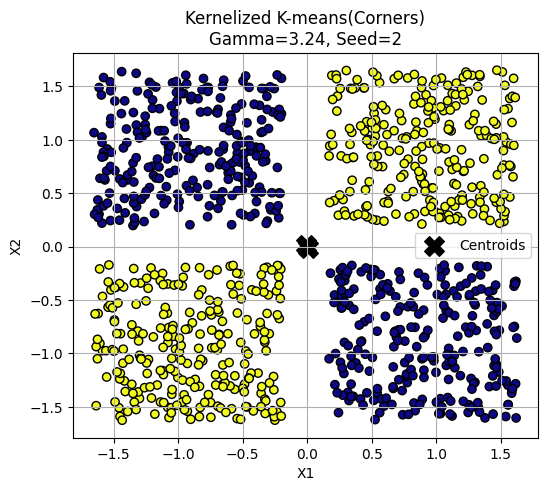

In [14]:
# import numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt


# make file for saving parameters
save_path = "my_saved_results/"


# define RBF kernel function
def rbf_kernel(X_data, gamma):
    sq_dists = np.sum((X_data[:, np.newaxis] - X_data[np.newaxis, :])**2, axis=2)
    return np.exp(-gamma * sq_dists)


# define kernel k-means class
class KMeans_Kernel:
    def __init__(self, n_clusters=2, iteration=100, gamma=10.0, seed=42):
        self.n_clusters = n_clusters
        self.iteration = iteration
        self.gamma = gamma
        self.seed = seed

    def training(self, X_data):
        self.X = X_data
        self.K = rbf_kernel(X_data, gamma=self.gamma)
        rng = np.random.default_rng(self.seed)
        self.labels_ = rng.integers(0, self.n_clusters, size=X_data.shape[0])

        for _ in range(self.iteration):
            clusters = [np.where(self.labels_ == i)[0] for i in range(self.n_clusters)]
            dist = np.zeros((X_data.shape[0], self.n_clusters))
            for i in range(self.n_clusters):
                if len(clusters[i]) == 0: continue
                K_cc = self.K[np.ix_(clusters[i], clusters[i])]
                K_ic = self.K[:, clusters[i]]
                N_c = len(clusters[i])
                dist[:, i] = (
                    self.K.diagonal()
                    - (2 / N_c) * np.sum(K_ic, axis=1)
                    + (1 / N_c**2) * np.sum(K_cc)
                )
            new_labels = np.argmin(dist, axis=1)
            if np.all(new_labels == self.labels_): break
            self.labels_ = new_labels

        # centroid (original space)
        self.centroids_ = np.array([
            self.X[self.labels_ == i].mean(axis=0) for i in range(self.n_clusters)
        ])

    def predict(self):
        return self.labels_

    def get_kernel(self):
        return self.K

    def get_centroids(self):
        return self.centroids_


# accuracy function
def clustering_accuracy(y_true, y_pred):
    return max(np.mean(y_true == y_pred), np.mean(y_true != y_pred))


# data
X_data = np.loadtxt("dataX.txt")
y_true = np.loadtxt("dataY.txt").astype(int)
X_data = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)


# searching best parameters
gamma_list = np.linspace(0.1, 20, 20)
seed_list = range(5)

best_acc = 0
for gamma in gamma_list:
    for seed in seed_list:
        model = KMeans_Kernel(n_clusters=2, gamma=gamma, seed=seed)
        model.training(X_data)
        pred = model.predict()
        acc = clustering_accuracy(y_true, pred)
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_labels = pred
            best_gamma = gamma
            best_seed = seed


# accuracy
print(f"Best Accuracy: {best_acc:.4f}")


# save parameters
np.save(save_path + "best_kernel_matrix.npy", best_model.get_kernel())
np.save(save_path + "best_centroids_original.npy", best_model.get_centroids())
np.save(save_path + "best_cluster_labels.npy", best_labels)
np.save(save_path + "best_gamma_seed.npy", np.array([best_gamma, best_seed]))


# visualization
plt.figure(figsize=(6, 5))
plt.scatter(X_data[:, 0], X_data[:, 1], c=best_labels, cmap="plasma", edgecolors='k')
plt.scatter(*best_model.get_centroids().T, s=200, marker='X', c='black', label="Centroids")
plt.title(f"Corners (Kernelized K-means)\nGamma={best_gamma:.2f}, Seed={best_seed}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()
plt.show()
